## In this project, i will build a random forest model to predict neonatal death using data used in logistic regression


In [28]:
# Installing libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline 

In [29]:
Neonetal_data=pd.read_csv("Neonatal_data_processed.csv")

Neonetal_data.head()

,AGE,GRAVIDA,PARITY,GESTATION AGE,TERM/PRETERM,HIV STATUS,MODE OF DELIVERY,AGPAR SCORE(1MIN),AGPAR SCORE(5MIN),SEX OF BABY,WEIGHT,PNC AT 6 HRS,PNC AT 24 HRS,BABY FINAL DIAGNOSIS,CAUSE OF DEATH GROUPED
0,25,2,1,38,0,0,0,8,10,1,3.5,1,1,0,NaN
1,17,1,0,39,0,0,0,5,7,1,2.9,1,1,0,NaN
2,28,9,8,37,0,0,0,8,9,0,3.3,1,1,0,NaN
3,42,8,7,36,0,0,0,7,9,0,3.1,1,1,0,NaN
4,30,1,0,38,0,0,0,8,9,1,3.4,1,1,0,NaN


In [30]:
Neonetal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5766 entries, 0 to 5765
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AGE                     5766 non-null   int64  
 1   GRAVIDA                 5766 non-null   int64  
 2   PARITY                  5766 non-null   int64  
 3   GESTATION AGE           5766 non-null   int64  
 4   TERM/PRETERM            5766 non-null   int64  
 5   HIV STATUS              5766 non-null   int64  
 6   MODE OF DELIVERY        5766 non-null   int64  
 7   AGPAR SCORE(1MIN)       5766 non-null   int64  
 8   AGPAR SCORE(5MIN)       5766 non-null   int64  
 9   SEX OF BABY             5766 non-null   int64  
 10  WEIGHT                  5766 non-null   float64
 11  PNC AT 6 HRS            5766 non-null   int64  
 12  PNC AT 24 HRS           5766 non-null   int64  
 13  BABY FINAL DIAGNOSIS    5766 non-null   int64  
 14  CAUSE OF DEATH GROUPED  126 non-null    

In [31]:
print(Neonetal_data.columns.tolist())

['AGE', 'GRAVIDA', 'PARITY', 'GESTATION AGE', 'TERM/PRETERM', 'HIV STATUS', 'MODE OF DELIVERY', 'AGPAR SCORE(1MIN)', 'AGPAR SCORE(5MIN)', 'SEX OF BABY', 'WEIGHT', 'PNC AT 6 HRS', 'PNC AT 24 HRS ', 'BABY FINAL DIAGNOSIS', 'CAUSE OF DEATH GROUPED']


**In this model, we shall use oversampled data since it performed well on logistic regression**

In [32]:
#Splitting data into X and y
target = "BABY FINAL DIAGNOSIS"
X = Neonetal_data.drop(columns=["BABY FINAL DIAGNOSIS", "CAUSE OF DEATH GROUPED"])
y=Neonetal_data["BABY FINAL DIAGNOSIS"]

# splitting data into train and test, 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=1
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4612, 13)
y_train shape: (4612,)
X_test shape: (1154, 13)
y_test shape: (1154,)


## Building model - Random Forest

In [33]:
# Creating a baseline for the accuracy
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9779


In [34]:
 # Make sure you're using imblearn's Pipeline, not sklearn's
# Define pipeline: oversample inside the fold, then fit the model
from imblearn.over_sampling import SMOTE

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
])

# Use StratifiedKFold to maintain class proportions in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_acc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

# Output results
print("Cross-validated Accuracy Scores:", cv_acc_scores)
print("Mean Accuracy:", round(cv_acc_scores.mean(), 4))


Cross-validated Accuracy Scores: [0.99566631 0.99241603 0.9967462  0.99457701 0.99566161]
Mean Accuracy: 0.995


In [35]:
# Define parameter grid (correcting the name of the step)
params = {
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10),
    "randomforestclassifier__class_weight": [{0:1, 1:5},'balanced']
}

# Define StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
model = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)


# Fit model
model.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters:", model.best_params_)
print("Best F1 Score:", round(model.best_score_, 4))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'randomforestclassifier__class_weight': {0: 1, 1: 5}, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 25}
Best F1 Score: 0.8519


## Evaluating models

In [36]:
# Predict on the test set
y_pred = model.predict(X_test)
# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", round(test_accuracy, 4))

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Set Accuracy: 0.9983
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1130
           1       0.96      0.96      0.96        24

    accuracy                           1.00      1154
   macro avg       0.98      0.98      0.98      1154
weighted avg       1.00      1.00      1.00      1154

Confusion Matrix:
 [[1129    1]
 [   1   23]]


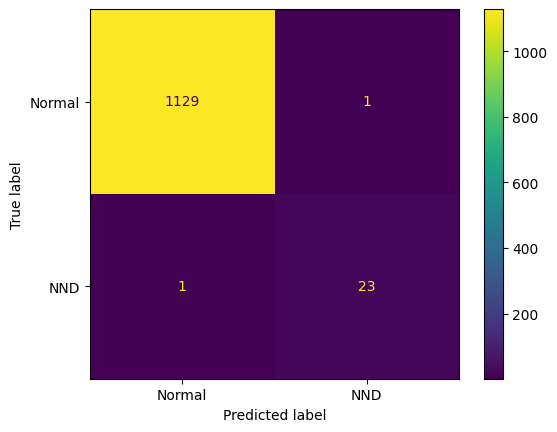

In [37]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Normal', 'NND']);

**Perfect model**

## Interpreting Results

In [38]:
# Get the final estimator from the pipeline
final_model = model.best_estimator_.named_steps['randomforestclassifier']

# Extract feature importances
feature_importances = pd.Series(final_model.feature_importances_, index=X_train.columns)

# Convert to DataFrame
feature_importance_df = feature_importances.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']

# Add interpretation
feature_importance_df['Interpretation'] = feature_importance_df['Importance'].apply(
    lambda x: 'Very influential' if x > 0.05 else ('Moderate' if x > 0.01 else 'Low influence')
)

# Sort and display top features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(10))


              Feature  Importance    Interpretation
8   AGPAR SCORE(5MIN)    0.470453  Very influential
12     PNC AT 24 HRS     0.252914  Very influential
7   AGPAR SCORE(1MIN)    0.125512  Very influential
11       PNC AT 6 HRS    0.036815          Moderate
10             WEIGHT    0.028519          Moderate
1             GRAVIDA    0.019957          Moderate
3       GESTATION AGE    0.016198          Moderate
2              PARITY    0.015817          Moderate
0                 AGE    0.015597          Moderate
4        TERM/PRETERM    0.006236     Low influence


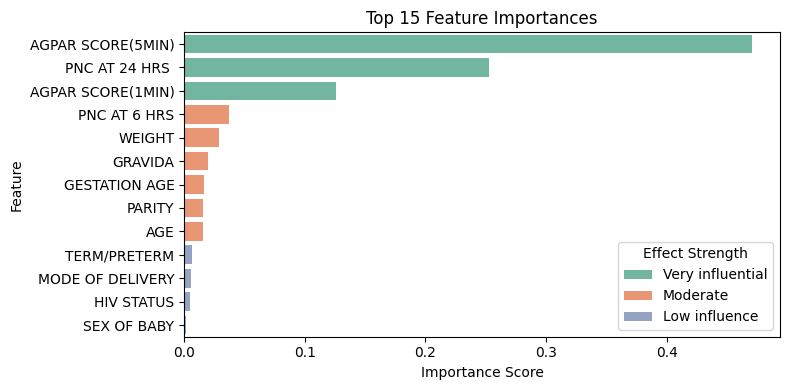

In [39]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(15),
    hue='Interpretation',
    dodge=False,
    palette='Set2'
)
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.legend(title='Effect Strength')
plt.tight_layout()
plt.show()


# INTERPRETING RESULTS WITH CAUSES OF DEATH

In [40]:
# Step 1: Add cause of death only for those who died (y == 1)
Neonetal_data['CAUSE OF DEATH GROUPED'] = np.where(y == 1, Neonetal_data['CAUSE OF DEATH GROUPED'], np.nan)

# Step 2: Add model predictions (if needed)
Neonetal_data['predicted_death'] = model.predict(X)

# Step 3: Filter rows where cause of death is known (actual deaths)
died_df = Neonetal_data[Neonetal_data['CAUSE OF DEATH GROUPED'].notna()]
died_df.head()

,AGE,GRAVIDA,PARITY,GESTATION AGE,TERM/PRETERM,HIV STATUS,MODE OF DELIVERY,AGPAR SCORE(1MIN),AGPAR SCORE(5MIN),SEX OF BABY,WEIGHT,PNC AT 6 HRS,PNC AT 24 HRS,BABY FINAL DIAGNOSIS,CAUSE OF DEATH GROUPED,predicted_death
5640,24,1,0,38,0,0,1,9,2,1,3.2,1,1,1,ASPHYXIA,1
5641,21,1,0,32,1,0,0,9,7,0,1.8,1,0,1,DISTRESS,1
5642,30,3,2,31,1,0,1,9,4,1,1.5,1,0,1,ASPHYXIA,1
5643,23,1,0,37,0,0,1,9,3,1,3.0,1,1,1,ASPHYXIA,1
5644,28,2,1,37,0,0,1,7,4,1,3.2,1,0,1,OTHERS,1


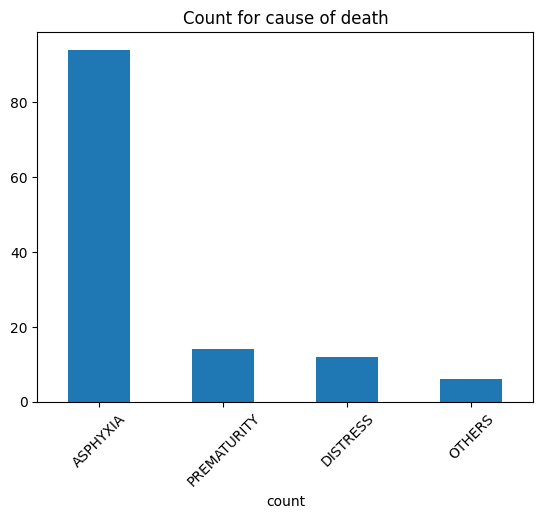

In [41]:
#Rank by cause of death
died_df["CAUSE OF DEATH GROUPED"].value_counts().sort_values(ascending=False).plot(kind="bar");
plt.title("Count for cause of death")
plt.xlabel("count")
plt.xticks(rotation=45);

<AxesSubplot: xlabel='Feature', ylabel='Mean Value'>

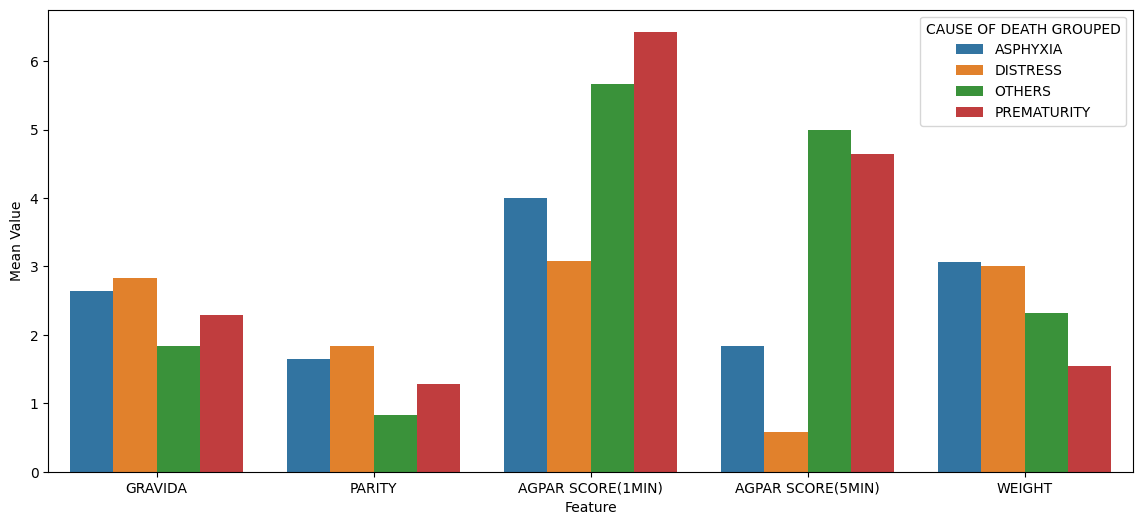

In [42]:
# Features to use for the first plot (excluding AGE and GESTATION AGE and categorical features)
features = [
    'GRAVIDA', 'PARITY', 'AGPAR SCORE(1MIN)', 'AGPAR SCORE(5MIN)', 'WEIGHT']

# Additional features to plot separately
extra_features = ['AGE', 'GESTATION AGE']

# Group and compute mean
grouped = died_df.groupby('CAUSE OF DEATH GROUPED')[features + extra_features]
mean_df = grouped.mean().reset_index()

# Melt for plotting
mean_df_melted = mean_df.melt(id_vars='CAUSE OF DEATH GROUPED', var_name='Feature', value_name='Mean Value')


# --- Plot 1: Other Features ---
plt.figure(figsize=(14, 6))
sns.barplot(
    data=mean_df_melted[mean_df_melted['Feature'].isin(features)],
    x='Feature', y='Mean Value', hue='CAUSE OF DEATH GROUPED'
)
#plo

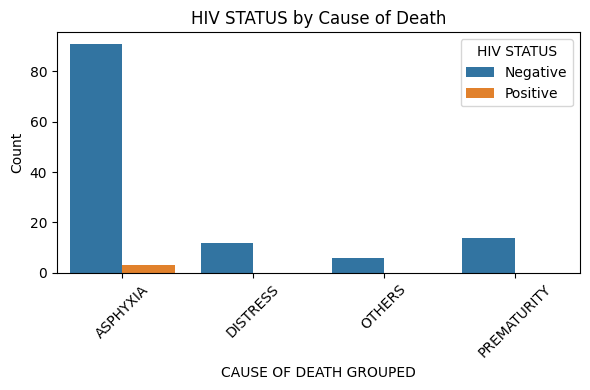

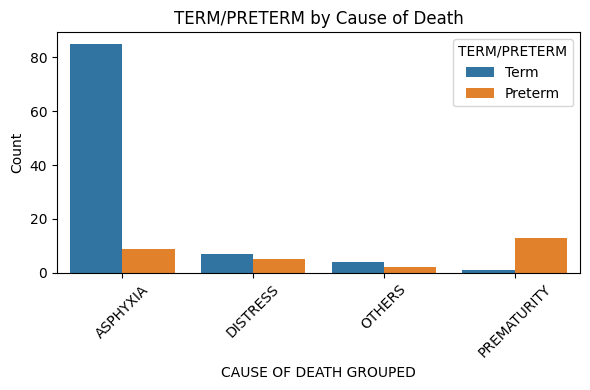

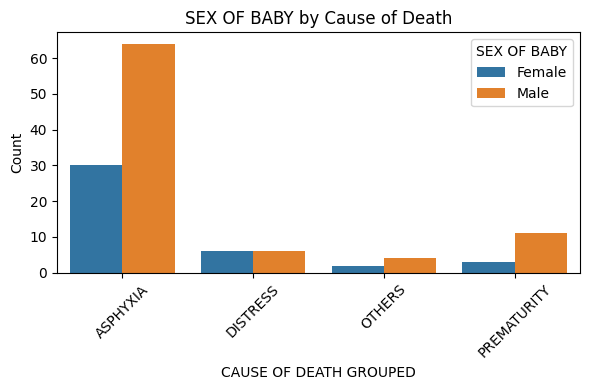

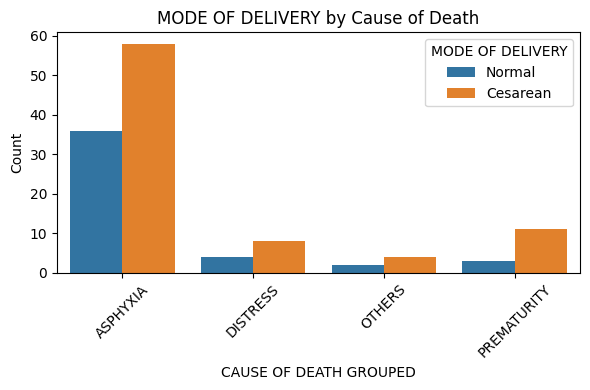

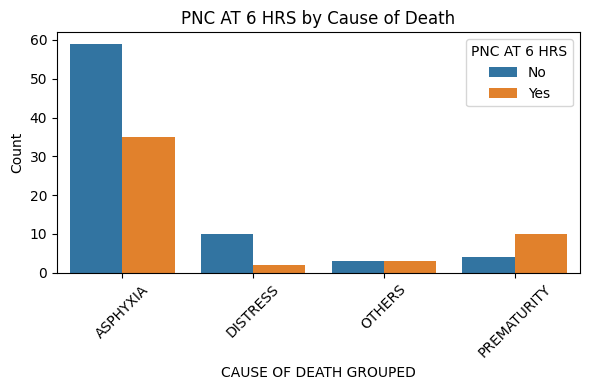

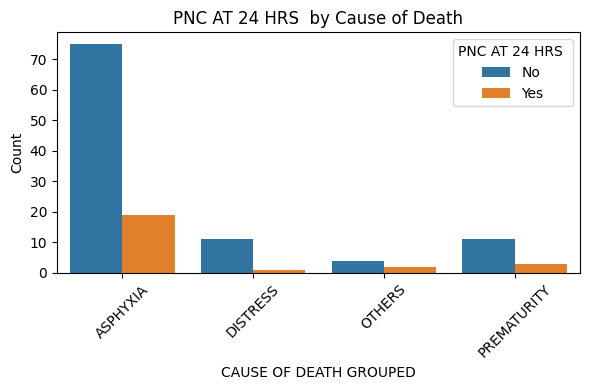

In [43]:
from IPython.display import display

# Define real-word labels for binary features
feature_labels = {
    'HIV STATUS': ['Negative', 'Positive'],
    'TERM/PRETERM': ['Term', 'Preterm'],
    'SEX OF BABY': ['Female', 'Male'],
    'MODE OF DELIVERY': ['Normal', 'Cesarean'],
    'PNC AT 6 HRS': ['No', 'Yes'],
    'PNC AT 24 HRS ': ['No', 'Yes']
}

# Loop through features and plot
for feature in feature_labels:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=died_df, x='CAUSE OF DEATH GROUPED', hue=feature)
    plt.title(f'{feature} by Cause of Death')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Update legend with real-word labels
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, title=feature, labels=feature_labels[feature])
    
    plt.tight_layout()
    display(plt.gcf())  # Show the current figure in its own output cell
    plt.close()


In [44]:
# After training your model with GridSearchCV
best_pipeline = model.best_estimator_

# Save the best pipeline to a file
import pickle
with open("RateOfDeath.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

print("✅ Best pipeline saved successfully as 'RateOfDeath.pkl'")





✅ Best pipeline saved successfully as 'RateOfDeath.pkl'
